In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import ast
import pickle
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import requests
import re
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phrases, Phraser
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
movies = pd.DataFrame(pickle.load(open('movies.pkl', 'rb')))
movies.head()

,title,imdb_id,poster_path,wiki_link,is_adult,year_of_release,genres,runtime,imdb_rating,story,actors,directors,writers,Emotion
0,Aag Ka Gola,tt0177489,https://upload.wikimedia.org/wikipedia/en/2/2a...,https://en.wikipedia.org/wiki/Aag_Ka_Gola,False,1990.0,"[Action, Drama]",180,5.4,Poverty and hunger forces young Shankar to tak...,"[Sunny Deol, Dimple Kapadia, Archana Puran Sin...",David Dhawan,"[Ram Kelkar, Faiz Saleem]","[{'anticipation': 0.03535353535353535, 'fear':..."
1,Ram Lakhan,tt0098168,https://image.tmdb.org/t/p/original/s6MeyQ0mL9...,https://en.wikipedia.org/wiki/Ram_Lakhan,0.0,1989.0,"[Action, Drama, Musical]",174,6.8,Sharda (Raakhee) vows vengeance when her husba...,"[Rakhee Gulzar, Jackie Shroff, Anil Kapoor, Di...",Subhash Ghai,"[Subhash Ghai, Ram Kelkar, Anwar Khan]","[{'anticipation': 0.05, 'anger': 0.04, 'joy': ..."
2,Asmaan Se Ooncha,tt0233146,https://image.tmdb.org/t/p/original/zhx8dgVHkQ...,https://en.wikipedia.org/wiki/Asmaan_Se_Ooncha,0.0,1989.0,"[Action, Drama, Family]",NaN,5.0,Anita lives an abusive life-style with her alc...,"[Jeetendra, Raj Babbar, Anita Raj, Govinda, So...",Mehul Kumar,[Pravin Bhatt],"[{'anticipation': 0.053763440860215055, 'fear'..."
3,Tridev,tt0100816,https://image.tmdb.org/t/p/original/fWg3vBcpKy...,https://en.wikipedia.org/wiki/Tridev,0.0,1989.0,"[Action, Crime, Drama]",173,6.3,Honest diligent and brave Police Inspector Ka...,"[Naseeruddin Shah, Sunny Deol, Jackie Shroff, ...",Rajiv Rai,"[Arshad Parvez, Rajiv Rai, K.K. Singh]","[{'anger': 0.06666666666666667, 'fear': 0.0666..."
4,ChaalBaaz,tt0122427,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/ChaalBaaz,False,NaN,[],NaN,6.7,Anju and Manju identical twins separated at b...,"[Sridevi, Sunny Deol, Rajinikanth, Anupam Kher...",Pankaj Parashar,"[Rajesh Mazumdar, Kamlesh Pandey, Pankaj Paras...","[{'trust': 0.04878048780487805, 'fear': 0.0243..."


In [ ]:
bollywood = pd.concat([pd.read_csv('indian movie database/1950-1989/bollywood_1950-1989.csv'),pd.read_csv('indian movie database/1990-2009/bollywood_1990-2009.csv'),pd.read_csv('indian movie database/2010-2019/bollywood_2010-2019.csv')])
bollywood_meta = pd.concat([pd.read_csv('indian movie database/1950-1989/bollywood_meta_1950-1989.csv'),pd.read_csv('indian movie database/1990-2009/bollywood_meta_1990-2009.csv'),pd.read_csv('indian movie database/2010-2019/bollywood_meta_2010-2019.csv')])
bollywood_ratings = pd.concat([pd.read_csv('indian movie database/1950-1989/bollywood_ratings_1950-1989.csv'),pd.read_csv('indian movie database/1990-2009/bollywood_ratings_1990-2009.csv'),pd.read_csv('indian movie database/2010-2019/bollywood_ratings_2010-2019.csv')])
bollywood_text = pd.concat([pd.read_csv('indian movie database/1950-1989/bollywood_text_1950-1989.csv'),pd.read_csv('indian movie database/1990-2009/bollywood_text_1990-2009.csv'),pd.read_csv('indian movie database/2010-2019/bollywood_text_2010-2019.csv')])
print(bollywood.shape,bollywood_meta.shape,bollywood_ratings.shape,bollywood_text.shape)

In [ ]:
movies = pd.merge(bollywood,bollywood_meta,how='outer',on=['imdb_id','title'])
movies = pd.merge(movies,bollywood_ratings,how='outer',on='imdb_id')
movies = pd.merge(movies,bollywood_text,how='outer',on='imdb_id')
movies.shape

In [ ]:
movies.drop_duplicates(inplace=True,ignore_index=True)
print(movies.shape)
movies.head()

In [ ]:
movies=movies.replace(r'\N',np.nan)

In [ ]:
movies.isnull().sum()

In [ ]:
movies=movies[movies['title'].notna()]
movies.isnull().sum()

In [ ]:
movies['poster_path']=movies['poster_path'].replace(np.nan,'https://upload.wikimedia.org/wikipedia/en/2/2a/404error')
movies['poster_path']=movies['poster_path'].replace('N/A','https://upload.wikimedia.org/wikipedia/en/2/2a/404error')
movies['is_adult']=movies['is_adult'].apply(lambda x:False)
movies.head()

In [ ]:
def get_response(i):
    title=movies.iloc[i].title.replace('#','%23')
    if(title.find('(') != -1):
        title=title[0:title.find('(')]
    url=f"https://api.themoviedb.org/3/search/movie?api_key=77eafb7a2d8d0876433444356f90b9d7&include_adult=true&query={title}"
    if(movies.iloc[i].year_of_release == movies.iloc[i].year_of_release):
        url=url+f"&year={movies.iloc[i].year_of_release}"
    response=requests.get(url)
#     print(url)
    data=response.json()
#     print(title)
    for movie in data['results']:
        if(movie['title'] == title):
            if(movie["poster_path"] != 'null'):
                movies.loc[i,'poster_path']=f'https://image.tmdb.org/t/p/original{movie["poster_path"]}'
            if(movie['adult'] != 'null'):
                movies.loc[i,'is_adult']=float(movie['adult'])
            break

In [ ]:
import time
for i in range(6270,movies.shape[0]):
    try:
        get_response(i)
    except:
        print(i)
        time.sleep(5)

In [ ]:
index=0
for i in movies.index:
    if(movies.iloc[i].poster_path.startswith('https://image.tmdb.')):
        index=i
print(index)
# print(len([movies.iloc[i].title for i in movies.index if "(" in movies.iloc[i]['title']]))
# print([movies.iloc[i] for i in movies.index if "film)" not in movies.iloc[i]['title'] and "(" in movies.iloc[i]['title']])
# movies=movies[movies['imdb_id'].notna()]
# movies.isnull().sum()
# movies.head()
# movies=movies.reset_index(drop=True)
# print(len([movies.iloc[i].title for i in movies.index if "(" in movies.iloc[i].title]))
# print(len([movies.iloc[i] for i in movies.index if "film)" in movies.iloc[i].title and "(" in movies.iloc[i].title]))
# print([(movies.iloc[i].title,movies.iloc[i].year_of_release) for i in movies.index if "film)" not in movies.iloc[i].title and "(" in movies.iloc[i].title])

In [ ]:
# movies['poster_path']=movies['poster_path'].replace(np.nan,'https://upload.wikimedia.org/wikipedia/en/2/2a/404error')
# movies['poster_path']=movies['poster_path'].replace('N/A','https://upload.wikimedia.org/wikipedia/en/2/2a/404error')
# import requests
# for i in movies.index:
# #     url=f'https://www.omdbapi.com/?t={movies.iloc[i].title}&apikey=5362ca82'
#     url=f'https://api.themoviedb.org/3/search/movie?api_key=77eafb7a2d8d0876433444356f90b9d7&query={movies.iloc[i].title}'
#     response=requests.get(movies.iloc[i].poster_path)
#     if(response.status_code != 200):
#         response=requests.get(url)
#         data=response.json()
#         if(len(data['results'])):
#             movies.loc[i,'poster_path']=f'https://image.tmdb.org/t/p/original/{data["results"][0]["poster_path"]}'

In [ ]:
crew=pd.read_csv('indian movie database/1950-2019/bollywood_crew_1950-2019.csv')
crew.head()

In [ ]:
writer=pd.read_csv('indian movie database/1950-2019/bollywood_writers_data_1950-2019.csv')
for i in crew.index:
    if(crew.iloc[i].writers == crew.iloc[i].writers):
        writers=crew.iloc[i].writers.split('|')
        writers_name=[]
        for writers_id in writers:
            for j in writer.index:
                if(writers_id == writer.iloc[j].crew_id):
                    writers_name.append(writer['name'][j])
                    break
        if(len(writers_name)):
            crew.loc[i,'writers'] = "|".join(writers_name)
        else:
            crew.loc[i,'writers'] = ''
    else:
        crew.loc[i,'writers'] = ''
crew.head()

In [ ]:
director=pd.read_csv('indian movie database/1950-2019/bollywood_crew_data_1950-2019.csv')
for i in crew.index:
    null=True
    for j in director.index:
        if(crew.iloc[i].directors == director.iloc[j].crew_id):
            crew.loc[i,'directors'] = director['name'][j]
            null=False
            break
    if(null):
        crew.loc[i,'directors'] = ''
crew.head()

In [ ]:
movies=pd.merge(movies,crew,on='imdb_id',how='left')
movies.head()

In [ ]:
movies.isnull().sum()

In [ ]:
# title
# imdb_id
# poster_path
# wiki_link
# is_adult
# year_of_release
# genres
# runtime
# imdb_rating
# summary
# tagline
# actors
# directors
# writers

In [ ]:
movies=movies[['title','imdb_id','poster_path','wiki_link','is_adult','year_of_release','genres','runtime','imdb_rating','story','actors','directors','writers']]
movies.drop_duplicates(inplace=True,ignore_index=True)
movies.head()

In [ ]:
movies['genres']=movies['genres'].replace(np.nan,'')
movies['actors']=movies['actors'].replace(np.nan,'')
movies['writers']=movies['writers'].replace(np.nan,'')
movies['genres'] = movies['genres'].apply(lambda x:x.split('|'))
movies['actors'] = movies['actors'].apply(lambda x:x.split('|'))
movies['writers'] = movies['writers'].apply(lambda x:x.split('|'))
movies.head()

In [ ]:
# movies_old = pd.DataFrame(pickle.load(open('movies.pkl', 'rb')))
# movies_old=movies_old.drop(['tags'],axis=1)
# movies=movies[pd.notnull(movies['imdb_id'])]
# movies_old=movies_old[['imdb_id','poster_path']]
# movies=movies.drop(['poster_path'],axis=1)
# movies=pd.merge(movies,movies_old,on='imdb_id',how='right')
# movies=movies.head(movies_old.shape[0])
# movies=movies.drop(['poster_path_x','poster_path_y','poster_path'],axis=1)
# movies=pd.concat([movies,movies_old],axis=1,keys=['imdb_id'])
# movies.to_clipboard(index=False)
# movies=pd.read_clipboard(sep='\t')
# movies.columns=movies.iloc[2]
# movies=pd.merge(movies,movies_old,on='imdb_id',how='left')
# movies=movies.drop(['index'],axis=1)
# movies=movies[pd.notnull(movies['imdb_id'])]
# movies.isnull().sum()
movies.iloc[0]

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
!pip install -U LeXmo
from LeXmo import LeXmo

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
movies.reset_index(drop=True)
movies.insert(loc=13,column="Emotion",value=np.nan)
movies.head()

,title,imdb_id,poster_path,wiki_link,is_adult,year_of_release,genres,runtime,imdb_rating,story,actors,directors,writers,Emotion
0,Aag Ka Gola,tt0177489,https://upload.wikimedia.org/wikipedia/en/2/2a...,https://en.wikipedia.org/wiki/Aag_Ka_Gola,False,1990.0,"[Action, Drama]",180,5.4,Poverty and hunger forces young Shankar to tak...,"[Sunny Deol, Dimple Kapadia, Archana Puran Sin...",David Dhawan,"[Ram Kelkar, Faiz Saleem]",NaN
1,Ram Lakhan,tt0098168,https://image.tmdb.org/t/p/original/s6MeyQ0mL9...,https://en.wikipedia.org/wiki/Ram_Lakhan,0.0,1989.0,"[Action, Drama, Musical]",174,6.8,Sharda (Raakhee) vows vengeance when her husba...,"[Rakhee Gulzar, Jackie Shroff, Anil Kapoor, Di...",Subhash Ghai,"[Subhash Ghai, Ram Kelkar, Anwar Khan]",NaN
2,Asmaan Se Ooncha,tt0233146,https://image.tmdb.org/t/p/original/zhx8dgVHkQ...,https://en.wikipedia.org/wiki/Asmaan_Se_Ooncha,0.0,1989.0,"[Action, Drama, Family]",NaN,5.0,Anita lives an abusive life-style with her alc...,"[Jeetendra, Raj Babbar, Anita Raj, Govinda, So...",Mehul Kumar,[Pravin Bhatt],NaN
3,Tridev,tt0100816,https://image.tmdb.org/t/p/original/fWg3vBcpKy...,https://en.wikipedia.org/wiki/Tridev,0.0,1989.0,"[Action, Crime, Drama]",173,6.3,Honest diligent and brave Police Inspector Ka...,"[Naseeruddin Shah, Sunny Deol, Jackie Shroff, ...",Rajiv Rai,"[Arshad Parvez, Rajiv Rai, K.K. Singh]",NaN
4,ChaalBaaz,tt0122427,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/ChaalBaaz,False,NaN,[],NaN,6.7,Anju and Manju identical twins separated at b...,"[Sridevi, Sunny Deol, Rajinikanth, Anupam Kher...",Pankaj Parashar,"[Rajesh Mazumdar, Kamlesh Pandey, Pankaj Paras...",NaN


In [36]:
for i in unvisited:
    if(movies.iloc[i].story == movies.iloc[i].story):
        emo=LeXmo.LeXmo(movies.iloc[i].story)
        emo.pop('text', None)
        dictionary=dict(sorted(emo.items(), key=lambda x:x[1],reverse=True))
        for key in ['positive','negative']:
            dictionary.pop(key, None)
        movies.loc[i,'Emotion']=[dictionary]
movies.head()

,title,imdb_id,poster_path,wiki_link,is_adult,year_of_release,genres,runtime,imdb_rating,story,actors,directors,writers,Emotion
0,Aag Ka Gola,tt0177489,https://upload.wikimedia.org/wikipedia/en/2/2a...,https://en.wikipedia.org/wiki/Aag_Ka_Gola,False,1990.0,"[Action, Drama]",180,5.4,Poverty and hunger forces young Shankar to tak...,"[Sunny Deol, Dimple Kapadia, Archana Puran Sin...",David Dhawan,"[Ram Kelkar, Faiz Saleem]","[{'anticipation': 0.03535353535353535, 'fear':..."
1,Ram Lakhan,tt0098168,https://image.tmdb.org/t/p/original/s6MeyQ0mL9...,https://en.wikipedia.org/wiki/Ram_Lakhan,0.0,1989.0,"[Action, Drama, Musical]",174,6.8,Sharda (Raakhee) vows vengeance when her husba...,"[Rakhee Gulzar, Jackie Shroff, Anil Kapoor, Di...",Subhash Ghai,"[Subhash Ghai, Ram Kelkar, Anwar Khan]","[{'anticipation': 0.05, 'anger': 0.04, 'joy': ..."
2,Asmaan Se Ooncha,tt0233146,https://image.tmdb.org/t/p/original/zhx8dgVHkQ...,https://en.wikipedia.org/wiki/Asmaan_Se_Ooncha,0.0,1989.0,"[Action, Drama, Family]",NaN,5.0,Anita lives an abusive life-style with her alc...,"[Jeetendra, Raj Babbar, Anita Raj, Govinda, So...",Mehul Kumar,[Pravin Bhatt],"[{'anticipation': 0.053763440860215055, 'fear'..."
3,Tridev,tt0100816,https://image.tmdb.org/t/p/original/fWg3vBcpKy...,https://en.wikipedia.org/wiki/Tridev,0.0,1989.0,"[Action, Crime, Drama]",173,6.3,Honest diligent and brave Police Inspector Ka...,"[Naseeruddin Shah, Sunny Deol, Jackie Shroff, ...",Rajiv Rai,"[Arshad Parvez, Rajiv Rai, K.K. Singh]","[{'anger': 0.06666666666666667, 'fear': 0.0666..."
4,ChaalBaaz,tt0122427,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/ChaalBaaz,False,NaN,[],NaN,6.7,Anju and Manju identical twins separated at b...,"[Sridevi, Sunny Deol, Rajinikanth, Anupam Kher...",Pankaj Parashar,"[Rajesh Mazumdar, Kamlesh Pandey, Pankaj Paras...","[{'trust': 0.04878048780487805, 'fear': 0.0243..."


In [5]:
for i in range(10):
    print(movies.iloc[i].story)
    print(movies.iloc[i].Emotion)

Poverty and hunger forces young Shankar to take up employment as a mechanic. To this extent all is well for him until he is arrested by the police for a crime he did not committed; but Shankar manages to escape only to witness that his mom die of shock; unable to bear the police arrest her son. Shankar is then taken in by a criminal don  Raja Babu who teaches him each and every criminal activity that exists. Years later Shankar is now known as Shakka who works for Raja Babu as a professional criminal. One day Shakka experiences a change of heart when he is asked to abducted a small child which results in the death of the mother; he turns himself into the police  the case is tried in court and Shakka is sentenced to five years imprisonment but because he save the life of a Minister his sentence is reduced to three years. When Shakka is released from jail he decides to give up his criminal ways  marry Aarti  buys a garage to earn his living and is the proud father of a baby boy Vicky ...

In [38]:
pickle.dump(movies.to_dict(),open('movies.pkl','wb'))

In [3]:
movies['genres'] = movies['genres'].apply(lambda x:[i.replace(" ","") for i in x])
movies['actors'] = movies['actors'].apply(lambda x:[i.replace(" ","") for i in x])
movies['directors'] = movies['directors'].str.replace(" ","")
movies['writers'] = movies['writers'].apply(lambda x:[i.replace(" ","") for i in x])
movies.head()

,title,imdb_id,poster_path,wiki_link,is_adult,year_of_release,genres,runtime,imdb_rating,story,actors,directors,writers
0,Aag Ka Gola,tt0177489,https://upload.wikimedia.org/wikipedia/en/2/2a...,https://en.wikipedia.org/wiki/Aag_Ka_Gola,False,1990.0,"[Action, Drama]",180,5.4,Poverty and hunger forces young Shankar to tak...,"[SunnyDeol, DimpleKapadia, ArchanaPuranSingh, ...",DavidDhawan,"[RamKelkar, FaizSaleem]"
1,Ram Lakhan,tt0098168,https://image.tmdb.org/t/p/original/s6MeyQ0mL9...,https://en.wikipedia.org/wiki/Ram_Lakhan,0.0,1989.0,"[Action, Drama, Musical]",174,6.8,Sharda (Raakhee) vows vengeance when her husba...,"[RakheeGulzar, JackieShroff, AnilKapoor, Dimpl...",SubhashGhai,"[SubhashGhai, RamKelkar, AnwarKhan]"
2,Asmaan Se Ooncha,tt0233146,https://image.tmdb.org/t/p/original/zhx8dgVHkQ...,https://en.wikipedia.org/wiki/Asmaan_Se_Ooncha,0.0,1989.0,"[Action, Drama, Family]",NaN,5.0,Anita lives an abusive life-style with her alc...,"[Jeetendra, RajBabbar, AnitaRaj, Govinda, Sona...",MehulKumar,[PravinBhatt]
3,Tridev,tt0100816,https://image.tmdb.org/t/p/original/fWg3vBcpKy...,https://en.wikipedia.org/wiki/Tridev,0.0,1989.0,"[Action, Crime, Drama]",173,6.3,Honest diligent and brave Police Inspector Ka...,"[NaseeruddinShah, SunnyDeol, JackieShroff, Mad...",RajivRai,"[ArshadParvez, RajivRai, K.K.Singh]"
4,ChaalBaaz,tt0122427,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/ChaalBaaz,False,NaN,[],NaN,6.7,Anju and Manju identical twins separated at b...,"[Sridevi, SunnyDeol, Rajinikanth, AnupamKher, ...",PankajParashar,"[RajeshMazumdar, KamleshPandey, PankajParashar]"


In [4]:
#string to list
movies['story']=movies['story'].replace(np.nan,'')
movies['directors']=movies['directors'].replace(np.nan,'')
movies['story']=movies['story'].apply(lambda x:x.split(" "))
movies['directors']=movies['directors'].apply(lambda x:x.split(" "))

In [6]:
movies['tags'] = movies['genres']+movies['story']
movies.head()
# movies.drop(['keywords','genres','overview','cast','crew'],axis = 1,inplace=True)

,title,imdb_id,poster_path,wiki_link,is_adult,year_of_release,genres,runtime,imdb_rating,story,actors,directors,writers,tags
0,Aag Ka Gola,tt0177489,https://upload.wikimedia.org/wikipedia/en/2/2a...,https://en.wikipedia.org/wiki/Aag_Ka_Gola,False,1990.0,"[Action, Drama]",180,5.4,"[Poverty, and, hunger, forces, young, Shankar,...","[SunnyDeol, DimpleKapadia, ArchanaPuranSingh, ...",[DavidDhawan],"[RamKelkar, FaizSaleem]","[Action, Drama, Poverty, and, hunger, forces, ..."
1,Ram Lakhan,tt0098168,https://image.tmdb.org/t/p/original/s6MeyQ0mL9...,https://en.wikipedia.org/wiki/Ram_Lakhan,0.0,1989.0,"[Action, Drama, Musical]",174,6.8,"[Sharda, (Raakhee), vows, vengeance, when, her...","[RakheeGulzar, JackieShroff, AnilKapoor, Dimpl...",[SubhashGhai],"[SubhashGhai, RamKelkar, AnwarKhan]","[Action, Drama, Musical, Sharda, (Raakhee), vo..."
2,Asmaan Se Ooncha,tt0233146,https://image.tmdb.org/t/p/original/zhx8dgVHkQ...,https://en.wikipedia.org/wiki/Asmaan_Se_Ooncha,0.0,1989.0,"[Action, Drama, Family]",NaN,5.0,"[Anita, lives, an, abusive, life-style, with, ...","[Jeetendra, RajBabbar, AnitaRaj, Govinda, Sona...",[MehulKumar],[PravinBhatt],"[Action, Drama, Family, Anita, lives, an, abus..."
3,Tridev,tt0100816,https://image.tmdb.org/t/p/original/fWg3vBcpKy...,https://en.wikipedia.org/wiki/Tridev,0.0,1989.0,"[Action, Crime, Drama]",173,6.3,"[Honest, , diligent, and, brave, Police, Inspe...","[NaseeruddinShah, SunnyDeol, JackieShroff, Mad...",[RajivRai],"[ArshadParvez, RajivRai, K.K.Singh]","[Action, Crime, Drama, Honest, , diligent, and..."
4,ChaalBaaz,tt0122427,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/ChaalBaaz,False,NaN,[],NaN,6.7,"[Anju, and, Manju, , identical, twins, separat...","[Sridevi, SunnyDeol, Rajinikanth, AnupamKher, ...",[PankajParashar],"[RajeshMazumdar, KamleshPandey, PankajParashar]","[, Anju, and, Manju, , identical, twins, separ..."


In [7]:
movies.isnull().sum()

title                 0
imdb_id               0
poster_path           0
wiki_link          1854
is_adult              0
year_of_release    1888
genres                0
runtime            3017
imdb_rating         395
story                 0
actors                0
directors             0
writers               0
tags                  0
dtype: int64

In [8]:
movies['tags']=movies['tags'].apply(lambda x:" ".join(x))
movies['tags']=movies['tags'].apply(lambda x:x.lower())

In [9]:
print(movies['tags'][0],movies['directors'][0])
movies.head(-5)

action drama poverty and hunger forces young shankar to take up employment as a mechanic. to this extent all is well for him until he is arrested by the police for a crime he did not committed; but shankar manages to escape only to witness that his mom die of shock; unable to bear the police arrest her son. shankar is then taken in by a criminal don  raja babu who teaches him each and every criminal activity that exists. years later shankar is now known as shakka who works for raja babu as a professional criminal. one day shakka experiences a change of heart when he is asked to abducted a small child which results in the death of the mother; he turns himself into the police  the case is tried in court and shakka is sentenced to five years imprisonment but because he save the life of a minister his sentence is reduced to three years. when shakka is released from jail he decides to give up his criminal ways  marry aarti  buys a garage to earn his living and is the proud father of a baby 

,title,imdb_id,poster_path,wiki_link,is_adult,year_of_release,genres,runtime,imdb_rating,story,actors,directors,writers,tags
0,Aag Ka Gola,tt0177489,https://upload.wikimedia.org/wikipedia/en/2/2a...,https://en.wikipedia.org/wiki/Aag_Ka_Gola,False,1990.0,"[Action, Drama]",180,5.4,"[Poverty, and, hunger, forces, young, Shankar,...","[SunnyDeol, DimpleKapadia, ArchanaPuranSingh, ...",[DavidDhawan],"[RamKelkar, FaizSaleem]",action drama poverty and hunger forces young s...
1,Ram Lakhan,tt0098168,https://image.tmdb.org/t/p/original/s6MeyQ0mL9...,https://en.wikipedia.org/wiki/Ram_Lakhan,0.0,1989.0,"[Action, Drama, Musical]",174,6.8,"[Sharda, (Raakhee), vows, vengeance, when, her...","[RakheeGulzar, JackieShroff, AnilKapoor, Dimpl...",[SubhashGhai],"[SubhashGhai, RamKelkar, AnwarKhan]",action drama musical sharda (raakhee) vows ven...
2,Asmaan Se Ooncha,tt0233146,https://image.tmdb.org/t/p/original/zhx8dgVHkQ...,https://en.wikipedia.org/wiki/Asmaan_Se_Ooncha,0.0,1989.0,"[Action, Drama, Family]",NaN,5.0,"[Anita, lives, an, abusive, life-style, with, ...","[Jeetendra, RajBabbar, AnitaRaj, Govinda, Sona...",[MehulKumar],[PravinBhatt],action drama family anita lives an abusive lif...
3,Tridev,tt0100816,https://image.tmdb.org/t/p/original/fWg3vBcpKy...,https://en.wikipedia.org/wiki/Tridev,0.0,1989.0,"[Action, Crime, Drama]",173,6.3,"[Honest, , diligent, and, brave, Police, Inspe...","[NaseeruddinShah, SunnyDeol, JackieShroff, Mad...",[RajivRai],"[ArshadParvez, RajivRai, K.K.Singh]",action crime drama honest diligent and brave ...
4,ChaalBaaz,tt0122427,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/ChaalBaaz,False,NaN,[],NaN,6.7,"[Anju, and, Manju, , identical, twins, separat...","[Sridevi, SunnyDeol, Rajinikanth, AnupamKher, ...",[PankajParashar],"[RajeshMazumdar, KamleshPandey, PankajParashar]",anju and manju identical twins separated at ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6477,Tera Kya Hoga Johnny,tt1221147,https://image.tmdb.org/t/p/original/7p82P5RVqV...,https://en.wikipedia.org/wiki/Tera_Kya_Hoga_Jo...,0.0,2009.0,"[Crime, Drama, Thriller]",155,6.0,"[Street-smart, Johnny, sells, coffee, in, Mumb...","[NeilNitinMukesh, ]",[SudhirMishra],"[PankajKapoor, SudhirMishra, NeeleshMisra, Jay...",crime drama thriller street-smart johnny sells...
6478,Ramaa: The Saviour,tt1279105,https://image.tmdb.org/t/p/original/b4u4jggBW4...,https://en.wikipedia.org/wiki/Ramaa:_The_Saviour,0.0,2010.0,"[Action, Adventure, Drama]",120,3.4,"[Snobbish, Komal, (Ananya, Shukla), and, her, ...","[SahilKhan, TanushreeDutta, MeghanJadhav, Kous...",[HadiAbrar],"[Kumaar, ReshuNath, KrupasagarSridharan]",action adventure drama snobbish komal (ananya ...
6479,I Hate Luv Storys,tt1667838,https://image.tmdb.org/t/p/original/fNw2XEa4jK...,https://en.wikipedia.org/wiki/I_Hate_Luv_Storys,0.0,2010.0,"[Comedy, Drama, Romance]",129,5.6,"[Born, from, a, Gujarati, mother, and, a, Punj...","[ImranKhan, SonamKapoor, SammirDattani, SamirS...",[PunitMalhotra],[PunitMalhotra],comedy drama romance born from a gujarati moth...
6480,Dulha Mil Gaya,tt1182884,https://image.tmdb.org/t/p/original/2Gi6RJ0KEq...,https://en.wikipedia.org/wiki/Dulha_Mil_Gaya,0.0,2010.0,"[Comedy, Drama, Romance]",152,4.2,"[After, the, passing, of, his, Trinidad-based,...","[SushmitaSen, FardeenKhan, IshitaSharma, ShahR...",[MudassarAziz],"[MudassarAziz, VivekVaswani]",comedy drama romance after the passing of his ...


In [10]:
# Function for removing ASCII characters
def _removeNonAscii(s):
    return "".join(i for i in s if ord(i)<128)

# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# Function for removing html
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

movies['tags'] = movies['tags'].apply(_removeNonAscii)
movies['tags'] = movies['tags'].apply(func = remove_stop_words)
movies['tags'] = movies['tags'].apply(func = remove_punctuation)
movies['tags'] = movies['tags'].apply(func = remove_html)

In [11]:
movies['tags'][0]

'action drama poverty hunger forces young shankar take employment mechanic extent well arrested police crime committed shankar manages escape witness mom die shock unable bear police arrest son shankar taken criminal raja babu teaches every criminal activity exists years later shankar known shakka works raja babu professional criminal one day shakka experiences change heart asked abducted small child results death mother turns police case tried court shakka sentenced five years imprisonment save life minister sentence reduced three years shakka released jail decides give criminal ways marry aarti buys garage earn living proud father baby boy vicky'

In [12]:
movies = movies.reset_index(drop=True)
movies.head()

,title,imdb_id,poster_path,wiki_link,is_adult,year_of_release,genres,runtime,imdb_rating,story,actors,directors,writers,tags
0,Aag Ka Gola,tt0177489,https://upload.wikimedia.org/wikipedia/en/2/2a...,https://en.wikipedia.org/wiki/Aag_Ka_Gola,False,1990.0,"[Action, Drama]",180,5.4,"[Poverty, and, hunger, forces, young, Shankar,...","[SunnyDeol, DimpleKapadia, ArchanaPuranSingh, ...",[DavidDhawan],"[RamKelkar, FaizSaleem]",action drama poverty hunger forces young shank...
1,Ram Lakhan,tt0098168,https://image.tmdb.org/t/p/original/s6MeyQ0mL9...,https://en.wikipedia.org/wiki/Ram_Lakhan,0.0,1989.0,"[Action, Drama, Musical]",174,6.8,"[Sharda, (Raakhee), vows, vengeance, when, her...","[RakheeGulzar, JackieShroff, AnilKapoor, Dimpl...",[SubhashGhai],"[SubhashGhai, RamKelkar, AnwarKhan]",action drama musical sharda raakhee vows venge...
2,Asmaan Se Ooncha,tt0233146,https://image.tmdb.org/t/p/original/zhx8dgVHkQ...,https://en.wikipedia.org/wiki/Asmaan_Se_Ooncha,0.0,1989.0,"[Action, Drama, Family]",NaN,5.0,"[Anita, lives, an, abusive, life-style, with, ...","[Jeetendra, RajBabbar, AnitaRaj, Govinda, Sona...",[MehulKumar],[PravinBhatt],action drama family anita lives abusive life s...
3,Tridev,tt0100816,https://image.tmdb.org/t/p/original/fWg3vBcpKy...,https://en.wikipedia.org/wiki/Tridev,0.0,1989.0,"[Action, Crime, Drama]",173,6.3,"[Honest, , diligent, and, brave, Police, Inspe...","[NaseeruddinShah, SunnyDeol, JackieShroff, Mad...",[RajivRai],"[ArshadParvez, RajivRai, K.K.Singh]",action crime drama honest diligent brave polic...
4,ChaalBaaz,tt0122427,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/ChaalBaaz,False,NaN,[],NaN,6.7,"[Anju, and, Manju, , identical, twins, separat...","[Sridevi, SunnyDeol, Rajinikanth, AnupamKher, ...",[PankajParashar],"[RajeshMazumdar, KamleshPandey, PankajParashar]",anju manju identical twins separated birth bor...


In [13]:
# Splitting the description into words
corpus = []
for words in movies['tags']:
    corpus.append(words.split())

In [14]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

EMBEDDING_FILE = 'C:/Users/user/gensim-data/word2vec-google-news-300/GoogleNews-vectors-negative300.bin'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary = True)

# Training our corpus with the model
google_model = Word2Vec(vector_size = 300, window = 5, min_count = 1, workers = -1)
google_model.build_vocab(corpus)
google_model.wv.vectors_lockf = np.ones(len(google_model.wv))

google_model.wv.intersect_word2vec_format(EMBEDDING_FILE, lockf = 1.0, binary = True)
google_model.train(corpus, total_examples = google_model.corpus_count, epochs = 5)

C:\Users\user/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz


(0, 0)

In [15]:
from numpy.linalg import norm
def cosine_similarity(word_embedding):
    similarity=[]
    for movie1 in word_embedding:
        if(not norm(movie1)):
            similarity.append((np.ones(len(word_embedding))*-1).tolist())
        else:
            similarity.append([np.dot(x,movie1)/(norm(movie1)*norm(x)) if len(x) else -1 for x in word_embedding])
    return similarity

In [16]:
def vectors(x):
    
    # Creating a list for storing the vectors ('Description' into vectors)
    global word_embeddings
    word_embeddings = []

    # Reading the each 'Description'
    for line in movies['tags']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in google_model.wv.key_to_index.keys():
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model.wv[word]
                else:
                    avgword2vec = avgword2vec + google_model.wv[word]
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
            word_embeddings.append(avgword2vec)
        else:
            word_embeddings.append([])
# Calling the function vectors
vectors(movies)

# Finding cosine similarity for the vectors
cosine_similarities = cosine_similarity(word_embeddings)

In [17]:
print(len(word_embeddings),movies.shape)

6484 (6484, 14)


In [18]:
movies['poster_path']=movies['poster_path'].replace(np.nan,'')

In [19]:
# Recommending the Top 5 similar movies
def recommendations(movie):
    # Taking the Title and Movie Image Link and store in new dataframe called 'movies'
    movies_new = movies[['title', 'poster_path']]

    # Reverse mapping of the index
    indices = pd.Series(movies.index, index = movies['title']).drop_duplicates()
         
    idx = indices[movie]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    recommend = movies.iloc[movie_indices]

    for index, row in recommend.iterrows():
        if(row['poster_path'] != ''):
            response = requests.get(row['poster_path'])
    #         print(response.status_code)
            if(response.status_code != 200):
                print(row['title'])
            else:
                img = Image.open(BytesIO(response.content))
                plt.figure()
                plt.imshow(img)
                plt.title(row['title'])
        else:
            print(row['title'])

In [20]:
# Building the TF-IDF model and calculating the TF-IDF score
tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 3), min_df = 2, stop_words = 'english')
tfidf.fit(movies['tags'])

# Getting the words from the TF-IDF model
tfidf_list = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

# TF-IDF words/column names
tfidf_feature = tfidf.get_feature_names()

In [21]:
# Storing the TFIDF Word2Vec embeddings
tfidf_vectors = [] 
line = 0

# For each 'Description'
for desc in corpus:

    # Word vectors are of zero length (using 300 dimensions)
    sent_vec = np.zeros(300) 

    # Number of words with a valid vector in the 'Description'
    weight_sum =0; 

    # For each word in the 'Description'
    for word in desc: 
        if word in google_model.wv.key_to_index.keys() and word in tfidf_feature:
            vec = google_model.wv[word]
            tf_idf = tfidf_list[word] * (desc.count(word) / len(desc))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    line += 1
# Finding cosine similarity for the vectors
cosine_similarities_2 = cosine_similarity(tfidf_vectors)

In [22]:
# cosine_similarities=cosine_similarities.tolist()
sl1 = sorted(enumerate(cosine_similarities[0]),key=lambda x:x[1],reverse=True)
sl2 = sorted(enumerate(cosine_similarities_2[0]),key=lambda x:x[1],reverse=True)
print(sl1)

[(0, 1.0), (1083, 0.9182159), (4615, 0.91383624), (4787, 0.9133095), (4616, 0.9127241), (3488, 0.9118077), (657, 0.91073626), (3489, 0.9092191), (4786, 0.9064908), (785, 0.9054067), (132, 0.90358573), (1154, 0.9031001), (131, 0.9019554), (1050, 0.9017164), (1153, 0.8999097), (4351, 0.89966106), (4486, 0.89859277), (5072, 0.89851403), (2203, 0.8977389), (1202, 0.89685833), (1242, 0.8960022), (4820, 0.8955375), (1517, 0.89437413), (4865, 0.89396787), (4576, 0.8918775), (228, 0.8914119), (5190, 0.89126277), (4579, 0.890468), (6257, 0.8897143), (4864, 0.8891367), (4033, 0.8889004), (1178, 0.88862157), (1241, 0.8878987), (1386, 0.88776964), (482, 0.88722205), (6256, 0.88721955), (1489, 0.8870226), (667, 0.8869049), (1518, 0.88648665), (1499, 0.88642704), (1843, 0.88639486), (4856, 0.8861746), (2544, 0.8857378), (4819, 0.8855567), (1621, 0.8854183), (642, 0.8853559), (4575, 0.88508254), (121, 0.88471943), (517, 0.88450456), (666, 0.88418114), (707, 0.8839887), (4371, 0.8837692), (2543, 0.883

In [23]:
print(sl2)

[(0, 1.0), (54, 0.856095550293784), (172, 0.838727642101398), (171, 0.8378675039894048), (785, 0.8288476137501497), (815, 0.8273237913325935), (56, 0.8217350555487785), (408, 0.8179750733974839), (215, 0.8174253933046225), (854, 0.8152162503796562), (835, 0.810407212804393), (264, 0.8098633544948861), (407, 0.8076950958953013), (266, 0.8044591451912646), (267, 0.8043109580591223), (818, 0.8043030124058429), (49, 0.8015017245256796), (568, 0.7974556866728651), (47, 0.7973500538717692), (48, 0.7960031274943201), (168, 0.795520931552904), (249, 0.7925760377075897), (17, 0.7825192040545391), (405, 0.7805326031250779), (3, 0.7803334939490116), (776, 0.7802367644925731), (777, 0.7800840083765599), (254, 0.7783938631421635), (270, 0.7761374020809313), (838, 0.7748601511579254), (41, 0.7678758557032248), (783, 0.7660331453709707), (40, 0.7656801666858836), (253, 0.765297084285994), (227, 0.7648055167068566), (863, 0.7640169382269237), (862, 0.7625185939922455), (223, 0.7622242251840311), (859,

In [24]:
# Recommending top 5 similar movies
def recommendations_2(movie):
    # Taking the Title and Image Link and store in new data frame called movies
    movies_new = movies[['title', 'poster_path']]
    
    # Reverse mapping of the index
    indices = pd.Series(movies.index, index = movies['title']).drop_duplicates()
        
    idx = indices[movie]
    sim_scores = list(enumerate(cosine_similarities_2[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    recommend = movies_new.iloc[movie_indices]
    for index, row in recommend.iterrows():
        if(row['poster_path'] != ''):
            response = requests.get(row['poster_path'])
    #         print(response.status_code)
            if(response.status_code != 200):
                print(row['title'])
            else:
                img = Image.open(BytesIO(response.content))
                plt.figure()
                plt.imshow(img)
                plt.title(row['title'])
        else:
            print(row['title'])

Procession of Memories


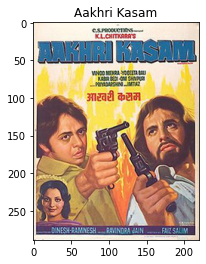

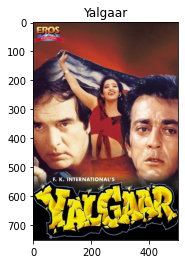

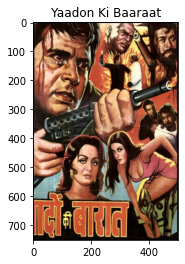

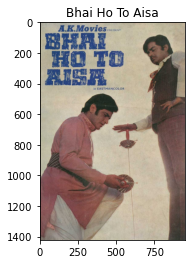

In [25]:
recommendations('Ram Lakhan')

Aisa Kyon Hota Hai?
Adharm
Aur Pappu Paas Ho Gaya
Veeru Dada
Pyaar Ka Mandir
Shankara (1991 film)


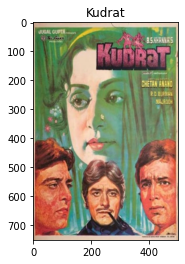

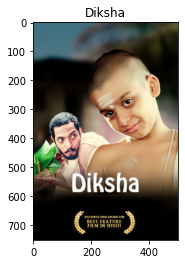

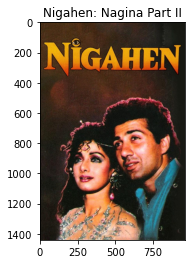

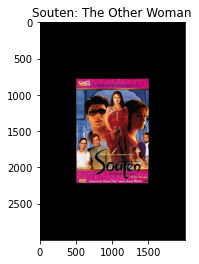

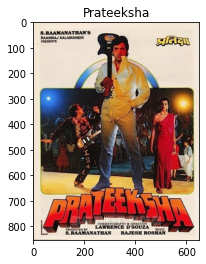

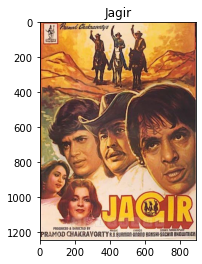

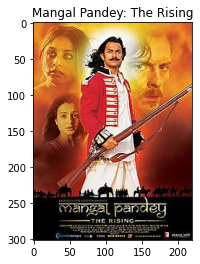

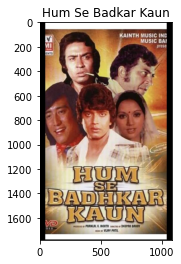

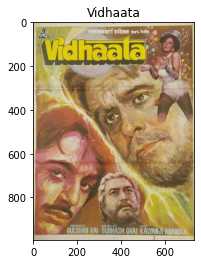

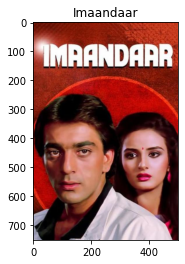

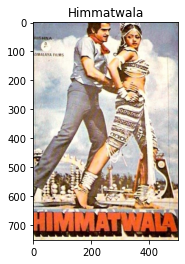

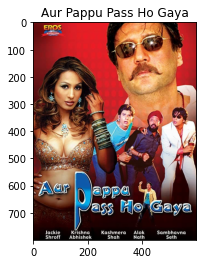

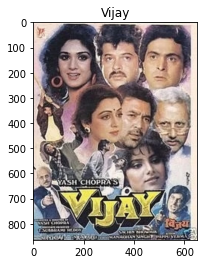

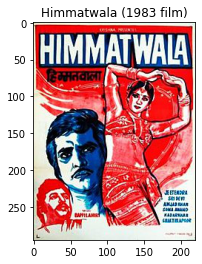

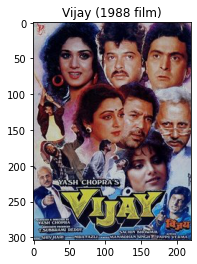

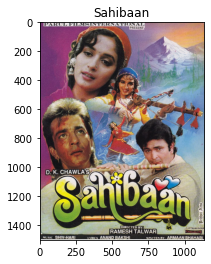

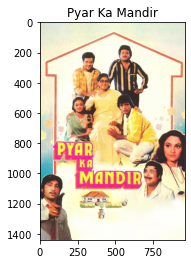

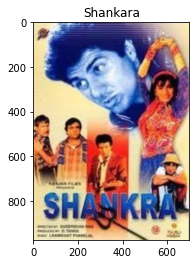

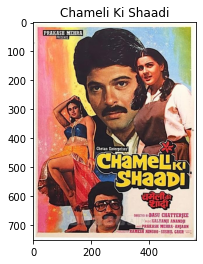

In [26]:
recommendations_2('Batwara')

In [27]:
# cosine_similarities=(np.array(cosine_similarities)+np.array(cosine_similarities_2))/2
# recommendations('Ram Lakhan')
cosine_similarities = [sorted(enumerate(x),key=lambda y:y[1],reverse=True)[:100] for x in cosine_similarities]
cosine_similarities_2 = [sorted(enumerate(x),key=lambda y:y[1],reverse=True)[:100] for x in cosine_similarities_2]

In [28]:
pickle.dump(cosine_similarities,open('similarity.pkl','wb'))
pickle.dump(cosine_similarities_2,open('similarity_2.pkl','wb'))

In [ ]:
movies=movies.reset_index(drop=True)
movies.head(-5)
def display_tag(movie):    
    for i in movies.index:
        if(movies.iloc[i].title == movie):
            print(movies.iloc[i].tags)
display_tag('The Ghazi Attack')
display_tag('Fight Club: Members Only')